In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [100]:
import time

In [101]:
import spacy

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Sprawdzanie czy w systemie jest karta graficzna Nvidia - CUDA

In [103]:
cuda_av = torch.cuda.is_available()
cuda_av

True

In [104]:
if cuda_av:
    cuda_id = torch.cuda.current_device()
    print(f'ID urządzenia CUDA: {cuda_id}')
    print(f"Nazwa urządzenia CUDA: {torch.cuda.get_device_name(cuda_id)}")

ID urządzenia CUDA: 0
Nazwa urządzenia CUDA: NVIDIA GeForce GTX 1070


In [105]:
# Tworzenie kodu uniwersalnego: dla CUDA i CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Ładowanie danych treningowych

In [106]:
tweets = pd.read_csv('data/olid-training-v1.0.tsv', sep='\t')

In [107]:
tweets.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [108]:
# tweets = tweets[:100]

In [109]:
# tweets = tweets[:5]

### Tokenizacja, lematyzacja, usówanie pewnych słów
liczenie najdłuższego przetworzonego tweeta

In [110]:
nlp = spacy.load('en_core_web_sm')

In [111]:
# dodawanie kolumny z tokenami
tweets['tokens'] = tweets['tweet'].apply(nlp)

In [112]:
tweets.head()

,id,tweet,subtask_a,subtask_b,subtask_c,tokens
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,"(@USER, She, should, ask, a, few, native, Amer..."
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"(@USER, @USER, Go, home, you, ’re, drunk, !, !..."
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,"(Amazon, is, investigating, Chinese, employees..."
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,"(@USER, Someone, should'veTaken, "", this, piec..."
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,"(@USER, @USER, Obama, wanted, liberals, &, amp..."


In [113]:
# dodawanie kolumny z lematami za pomoca funkcji lambda - przy tym usuwanie:
# odwolan do wczesniejszych tweetow (zawiera @)
# - slowa url (czyli adresy stron inernetowych które w danych wejściowych mają URL zamiast adreasu.
# # - hasztagów; przyimków i innych częstych słów (stop words) oraz znaków interpunkcyjnych.
# spacji ' ', '  ', '   '

# emotikony zostawiam - uważam, że też niosą znaczenie

tweets['lemmas'] = tweets['tokens'].apply\
    (lambda list_tokens : [token.lemma_.strip() for token in list_tokens if ('@' not in token.lemma_ \
                                                                     and '#' not in token.lemma_ and 'url' not in token.lemma_ \
                                                                     and not token.is_stop and not token.is_punct and token.lemma_ != ' ' \
                                                                     and token.lemma_ != '  ' and token.lemma_ != '   '
                                                                     and token.lemma_ != '    ')])

In [114]:
tweets.loc[:3,'lemmas']

0                             [ask, native, Americans]
1           [home, drunk, MAGA, Trump2020, 👊, 🇺, 🇸, 👊]
2    [Amazon, investigate, chinese, employee, sell,...
3            [should'vetaken, piece, shit, volcano, 😂]
Name: lemmas, dtype: object

In [115]:
tweets.loc[11, 'tokens']

@USER What’s the difference between #Kavanaugh and @USER   One of these men admitted to groping a 15 year old girl years ago.  The other is going to be #confirmed to the SCJ   #DemsareFrauds #DemsAreDone   #WalkAwayDemocrats2018 #redwave #VoteRedSaveAmerica #trumptrain #MAGA URL

In [116]:
tweets['length_lemmas'] = tweets['lemmas'].apply(lambda row: len(row))

In [117]:
tweets.loc[:10, 'length_lemmas']

0      3
1      8
2     18
3      5
4      7
5      2
6      4
7     16
8      2
9     10
10     4
Name: length_lemmas, dtype: int64

In [118]:
max_length_tweet = max(tweets['length_lemmas'])

## Ładowanie danych testowych(a)

In [119]:
test_level_a = pd.read_csv('data/testset-levela.tsv', sep='\t')

In [120]:
labels_level_a = pd.read_csv('data/labels-levela.csv', header=None)

In [121]:
labels_level_a = labels_level_a.rename(columns={0:'id', 1:'subtask_a'})

In [122]:
test_a = pd.merge(test_level_a, labels_level_a, on = "id", how = "inner")

In [123]:
test_a.head()

,id,tweet,subtask_a
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF


In [124]:
len(test_a)

860

### Opracowanie danych testowych (część a)
Takie same modyfikacje jak dla danych treningowych

In [125]:
test_a['tokens'] = test_a['tweet'].apply(nlp)
test_a['lemmas'] = test_a['tokens'].apply \
    (lambda list_tokens : [token.lemma_.strip() for token in list_tokens if ('@' not in token.lemma_ \
                                                                             and '#' not in token.lemma_ and 'url' not in token.lemma_ \
                                                                             and not token.is_stop and not token.is_punct and token.lemma_ != ' ' \
                                                                             and token.lemma_ != '  ' and token.lemma_ != '   ' \
                                                                             and token.lemma_ != '    ')])

test_a['length_lemmas'] = test_a['lemmas'].apply(lambda row: len(row))

In [126]:
max(test_a['length_lemmas'])

40

In [127]:
test_a.head()

,id,tweet,subtask_a,tokens,lemmas,length_lemmas
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,"(#, WhoIsQ, #, WheresTheServer, #, DumpNike, #...","[WhoIsQ, wherestheserver, DumpNike, DECLASFISA...",24
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,"(#, ConstitutionDay, is, revered, by, Conserva...","[ConstitutionDay, revere, conservative, hate, ...",9
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,"(#, FOXNews, #, NRA, #, MAGA, #, POTUS, #, TRU...","[foxnew, NRA, MAGA, POTUS, TRUMP, 2ndamendment...",15
3,13876,#Watching #Boomer getting the news that she is...,NOT,"(#, Watching, #, Boomer, getting, the, news, t...","[watch, Boomer, get, news, parole, make, smile...",10
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,"(#, NoPasaran, :, Unity, demo, to, oppose, the...","[NoPasaran, unity, demo, oppose, far, right, L...",9


In [128]:
len(test_a)

860

In [129]:
max_length_tweet_test = max(test_a['length_lemmas'])

In [130]:
max_length_tweet_test

40

In [131]:
#### Maksymalna długość wektora z lematami z tweetów

In [132]:
max_width = max(max_length_tweet, max_length_tweet_test)

## Funkcje do przekszałcania danych

In [133]:
def convert_words_to_numbers(lemmas_series, dict_ = dict()):
    # dict_ = dict()
    for row in lemmas_series:
        for lemma in row:
            if lemma not in dict_:
                dict_[lemma] = len(dict_) + 1

    return dict_

In [134]:
def lemmas_to_numbers(row, max_list_lemmas, dict_):
    list_numbers = []
    for i in range(max_list_lemmas - len(row)):
        list_numbers.append(0)

    for lemma in row:
        list_numbers.append(dict_[lemma])

    array_numbers = np.array(list_numbers, dtype=np.int32)
    return array_numbers

## Powrót do opracowywania danych treningowych

In [135]:
dict_lemmas = convert_words_to_numbers(tweets['lemmas'])

In [136]:
sorted(dict_lemmas)[:10]

['', '$', '&amp', "'cause", "'em", '(sorry', '*disclaimer', '+', '+15', '+2']

In [137]:
# zamiana lematu na liczbe ze slownika ktory odpowiada danemu slowu
tweets['numbers'] = tweets['lemmas'].apply(lambda row : lemmas_to_numbers(row, max_width, dict_lemmas))

In [138]:
tweets['numbers'].head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: numbers, dtype: object

In [139]:
# przypisywanie X_train kolumny numbers skonwertowanej na tablice numpy
X_train = tweets['numbers'].values

In [140]:
# łączenie wierszy tablic w jedną tablicę 2D
X_train = np.stack(X_train)

In [141]:
# konwertowanie tablicy 2d do tensora
X_train = torch.FloatTensor(X_train)

In [142]:
# ustawianie kolumn z etykietami na poszczególne zadania jako type które przechowują kategorie

In [143]:
cat_cols = ['subtask_a', 'subtask_b', 'subtask_c']

In [144]:
for col in cat_cols:
    tweets[col] = tweets[col].astype('category')

In [145]:
tweets['labels_a'] = tweets['subtask_a'].cat.codes

In [146]:
# OFFENSIVE jest jako 1, a NOT OFFENSIVE jest jako 0
tweets.loc[:5, 'labels_a']

0    1
1    1
2    0
3    1
4    0
5    1
Name: labels_a, dtype: int8

In [147]:
tweets

,id,tweet,subtask_a,subtask_b,subtask_c,tokens,lemmas,length_lemmas,numbers,labels_a
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,"(@USER, She, should, ask, a, few, native, Amer...","[ask, native, Americans]",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"(@USER, @USER, Go, home, you, ’re, drunk, !, !...","[home, drunk, MAGA, Trump2020, 👊, 🇺, 🇸, 👊]",8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,"(Amazon, is, investigating, Chinese, employees...","[Amazon, investigate, chinese, employee, sell,...",18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,"(@USER, Someone, should'veTaken, "", this, piec...","[should'vetaken, piece, shit, volcano, 😂]",5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,"(@USER, @USER, Obama, wanted, liberals, &, amp...","[Obama, want, liberal, amp, illegal, red, state]",7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
...,...,...,...,...,...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND,"(@USER, Sometimes, I, get, strong, vibes, from...","[strong, vibe, people, man, vibe, ten, million...",10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN,"(Benidorm, ✅, , Creamfields, ✅, , Maga, ✅, ...","[benidorm, ✅, creamfield, ✅, Maga, ✅, shabby, ...",8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH,"(@USER, And, why, report, this, garbage, ., ,...","[report, garbage, crap]",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
13238,27429,@USER Pussy,OFF,UNT,NaN,"(@USER, Pussy)",[Pussy],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [148]:
tweets.iloc[0]

id                                                           86426
tweet            @USER She should ask a few native Americans wh...
subtask_a                                                      OFF
subtask_b                                                      UNT
subtask_c                                                      NaN
tokens           (@USER, She, should, ask, a, few, native, Amer...
lemmas                                    [ask, native, Americans]
length_lemmas                                                    3
numbers          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
labels_a                                                         1
Name: 0, dtype: object

In [149]:
y_train = tweets['labels_a'].values

In [150]:
y_train = torch.tensor(y_train).reshape(-1,1)

In [151]:
y_train[:5]

tensor([[1],
        [1],
        [0],
        [1],
        [0]], dtype=torch.int8)

In [152]:
data = torch.cat((X_train, y_train), axis=1)

In [153]:
data = data.to(device)

## Opracowywanie danych testowych

In [154]:
dict_lemmas = convert_words_to_numbers(test_a['lemmas'], dict_lemmas)

In [155]:
sorted(dict_lemmas)[:10]

['', '$', '&amp', "'cause", "'em", '(sorry', '*disclaimer', '+', '+15', '+2']

In [156]:
# zamiana lematu na liczbe ze slownika ktory odpowiada danemu slowu
test_a['numbers'] = test_a['lemmas'].apply(lambda row : lemmas_to_numbers(row, max_width, dict_lemmas))

In [157]:
test_a['lemmas'].head()

0    [WhoIsQ, wherestheserver, DumpNike, DECLASFISA...
1    [ConstitutionDay, revere, conservative, hate, ...
2    [foxnew, NRA, MAGA, POTUS, TRUMP, 2ndamendment...
3    [watch, Boomer, get, news, parole, make, smile...
4    [NoPasaran, unity, demo, oppose, far, right, L...
Name: lemmas, dtype: object

In [158]:
test_a.loc[:5, 'numbers']

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: numbers, dtype: object

### Robienie tego samego procesu co wcześniej dla danych testowych


In [159]:
X_test = test_a['numbers'].values


In [160]:
X_test = np.stack(X_test)

In [161]:
X_test = torch.FloatTensor(X_test)

In [162]:
# cat_cols = ['subtask_a', 'subtask_b', 'subtask_c']
# for col in cat_cols:
#     X_test[col] = X_test[col].astype('category')

In [163]:
test_a['subtask_a'] = test_a['subtask_a'].astype('category')

In [164]:
test_a['labels_a'] = test_a['subtask_a'].cat.codes

In [165]:
# OFFENSIVE jest jako 1, a NOT OFFENSIVE jest jako 0
test_a.loc[:5, 'labels_a']

0    1
1    0
2    0
3    0
4    1
5    1
Name: labels_a, dtype: int8

In [166]:
y_test = test_a['labels_a'].values

In [167]:
y_test = torch.tensor(y_test).reshape(-1,1)

In [168]:
y_test[:5]

tensor([[1],
        [0],
        [0],
        [0],
        [1]], dtype=torch.int8)

In [169]:
data_test_a = torch.cat((X_test, y_test), axis=1)

In [170]:
data_test_a = data_test_a.to(device)

## Definiowanie modelu

In [171]:
class Model(nn.Module):
    def __init__(self, in_features=18, h1=80, h2=50, h3=None, embedding_dim=None, vocab_size=0, out_features=1):
        super().__init__()

        # warstwa embeddingów
        if (embedding_dim is not None and vocab_size > 0):
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # dropout layer - losowe pomijanie uczenia się pewnych neuronów
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(embedding_dim * in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        if h3 is None:
            self.out = nn.Linear(h2, out_features)
        # self.sig = nn.Sigmoid()
        else:
            self.fc3 = nn.Linear(h2, h3)
            self.out = nn.Linear(h3, out_features)


    def forward(self, x):
        # print(x.shape)
        x = x.long()
        # print(x.shape)
        embeds = self.embedding(x)
        # print(embeds.shape)
        embeds = embeds.view(embeds.shape[0], -1)
        # print(embeds.shape)
        x = torch.sigmoid(self.fc1(embeds))
        # x = self.dropout(x)

        x = torch.sigmoid(self.fc2(x))
        # x = self.dropout(x)

        if h3 is not None:
            x = torch.sigmoid(self.fc3(x))
            x = self.dropout(x)
        x = torch.sigmoid(self.out(x))

        return x

## Ustawnia modelu i sieci

In [172]:
print('max width: 73')

max width: 73


In [280]:
epochs = 10
learning_rate = 0.01
batch_size = 1000
vocab_size = len(dict_lemmas) + 1
embedding_dim = 5
h1 = 100
h2 = 100
h3 = None


In [281]:
train_dataset_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
test_dataset_loader_a = torch.utils.data.DataLoader(data_test_a, batch_size=batch_size, shuffle=True)

## Tworzenie instancji modelu
Ustawianie funkcji straty i optymalizatora

In [282]:
# tworzenie numpy array z listy liczb (odpowiadających lematom)

In [283]:
max_width

73

In [284]:
torch.manual_seed(32)
model = Model(max_width, h1, h2, h3, embedding_dim, vocab_size)

In [285]:
model = model.to(device)

In [286]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [287]:
model

Model(
  (embedding): Embedding(21586, 5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=365, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
)

### Ustawianie nauki sieci i samo uczenie się

In [288]:
losses = []
losses_test = []
accuracy = []
accuracy_test = []
train_count = len(tweets)
test_count_a = len(test_a)

In [289]:
start_time = time.time()
for e in range(epochs):
    loss_epoch = torch.empty(0)
    correct_epoch = 0

    loss_epoch_test = np.empty(0)
    correct_epoch_test = 0

    for batch_num, batch in enumerate(train_dataset_loader):
        X_train = batch[:,:-1]
        y_train = batch[:,-1].reshape(-1,1)
        y_pred = model.forward(X_train)

        loss = criterion(y_pred, y_train)
        if (e == 0 and batch_num == 0):
            print(f'Loss on the first batch: {loss}')

        # print(loss.item())
        loss_epoch = np.append(loss_epoch, loss.detach().cpu().numpy())
        # losses.append(loss.item())


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        predicted = torch.round(y_pred)
        # print(y_train)
        predicted = (predicted == y_train).sum().cpu()
        pred_cpu = predicted.cpu()
        # print(f'pred_cpu: {pred_cpu}')
        correct_epoch += predicted

# przechodzenie przez dane testowe - nie ucząc sieci
    with torch.no_grad():
        for batch_num_test, batch_test in enumerate(test_dataset_loader_a):
            X_test = batch_test[:,:-1]
            y_test = batch_test[:,-1].reshape(-1,1)
            y_pred_test = model.forward(X_test)

            loss_test = criterion(y_pred_test, y_test)
            if (e == 0 and batch_num_test == 0):
                print(f'Loss on the first batch on test data: {loss_test}')
                print(loss_test.shape)

            # print(loss.item())
            loss_epoch_test = np.append(loss_epoch_test, loss_test.item())
            # print(loss_test)
            # losses.append(loss.item())

            predicted = torch.round(y_pred_test)
            # print(predicted)
            # print(y_test)
            predicted = (predicted == y_test).sum()
            pred_cpu = predicted.cpu()
            # print(f'pred_cpu: {pred_cpu}')
            correct_epoch_test += predicted

        loss_epoch_test = loss_epoch_test.sum() / test_count_a
        losses_test.append(loss_epoch_test)
        accuracy_epoch_test = correct_epoch_test * 100/test_count_a
        accuracy_epoch_test_cpu = accuracy_epoch_test.cpu()
        accuracy_test.append(accuracy_epoch_test_cpu)

    loss_epoch = loss_epoch.sum() / train_count
    losses.append(loss_epoch)
    accuracy_epoch = correct_epoch * 100/train_count
    accuracy_epoch_cpu = accuracy_epoch.cpu()
    accuracy.append(accuracy_epoch)


    # print(f'Test accuracy: {correct_epoch.item()}/{train_count} = {correct.item() * 100 / (test_count):7.3f}%')
    print(f' epoch: {e} | loss: {loss_epoch} | predicted: {correct_epoch} | accuracy: {accuracy_epoch} | test loss: {loss_epoch_test} | ' \
          + f'predicted: {correct_epoch_test} | test accuracy: {accuracy_epoch_test}')

duration = time.time() - start_time

Loss on the first batch: 0.6456607580184937
Loss on the first batch on test data: 0.599708616733551
torch.Size([])
 epoch: 0 | loss: 0.0006909724088593912 | predicted: 8840 | accuracy: 66.76737213134766 | test loss: 0.0006973356008529663 | predicted: 620 | test accuracy: 72.09302520751953
 epoch: 1 | loss: 0.0006745918999985985 | predicted: 8840 | accuracy: 66.76737213134766 | test loss: 0.0006942696349565373 | predicted: 620 | test accuracy: 72.09302520751953
 epoch: 2 | loss: 0.0006713376664683177 | predicted: 8840 | accuracy: 66.76737213134766 | test loss: 0.0007001576035521751 | predicted: 620 | test accuracy: 72.09302520751953
 epoch: 3 | loss: 0.0006649592131646379 | predicted: 8840 | accuracy: 66.76737213134766 | test loss: 0.0007028382184893586 | predicted: 620 | test accuracy: 72.09302520751953
 epoch: 4 | loss: 0.0006378165904848957 | predicted: 8842 | accuracy: 66.78247833251953 | test loss: 0.0006748411544533664 | predicted: 611 | test accuracy: 71.0465087890625
 epoch: 5 |

## Rysowanie funkcji straty i accuracy na przestrzeni epok

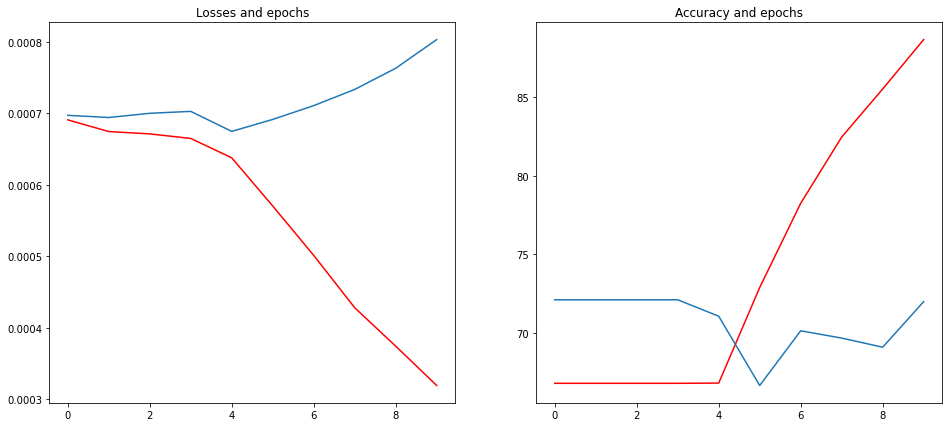

In [290]:
## Plot loss functions over epochs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))


ax1.plot(range(epochs), losses, c='r')
ax1.plot(range(epochs), losses_test)
ax1.set_title('Losses and epochs')

ax2.plot(range(epochs), accuracy, c='r')
ax2.plot(range(epochs), accuracy_test)
ax2.set_title("Accuracy and epochs")

plt.show()

In [278]:
# dictionary storing the data
summary = {
    "Training": [min(losses), max(accuracy)],
    "Test": [min(losses_test), max(accuracy_test)]
}

# dataframe from dict
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Loss', 'Accuracy'])

In [279]:
print(model)
print('learning_rate: ', learning_rate)
print('batch_size: ', batch_size)
print('time: ', duration)

Model(
  (embedding): Embedding(21586, 5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=365, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
)
learning_rate:  0.01
batch_size:  1000
time:  8.464115142822266


In [200]:
summary_df

,Loss,Accuracy
Training,0.000205,tensor(79.6903)
Test,0.000690,tensor(72.0930)
